# **Introduction to deep learning for computer vision**

### Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavthupili","key":"86ccc6c3cbf802a01948d9f1fc194665"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:27<00:00, 29.7MB/s]
100% 812M/812M [00:28<00:00, 30.4MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=8000)
make_subset("validation", start_index=8000, end_index=8250)
make_subset("test", start_index=8250, end_index=8500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [19]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

# **Training = 8000; Validation = 500; Test = 500**

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 16000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [21]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [22]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [23]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [24]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [25]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - 20s 35ms/step - loss: 0.0723 - accuracy: 0.9788 - val_loss: 0.4920 - val_accuracy: 0.8920
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0375 - accuracy: 0.9877 - val_loss: 0.5766 - val_accuracy: 0.8960
Epoch 3/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0422 - accuracy: 0.9854 - val_loss: 0.7797 - val_accuracy: 0.8740
Epoch 4/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0459 - accuracy: 0.9846 - val_loss: 0.6017 - val_accuracy: 0.8980
Epoch 5/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.5668 - val_accuracy: 0.9080
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0605 - accuracy: 0.9808 - val_loss: 0.3587 - val_accuracy: 0.9180
Epoch 7/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0334 - accuracy: 0.9884 - val_loss: 0.4702 - val_accuracy:

**Displaying curves of loss and accuracy during training**

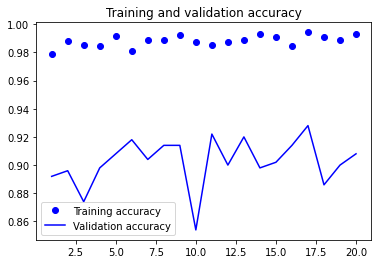

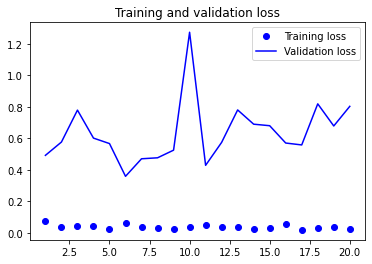

In [27]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [28]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 16ms/step - loss: 0.4193 - accuracy: 0.9020
Test accuracy: 0.902


# **Using data augmentation**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# **Displaying some randomly augmented training images**

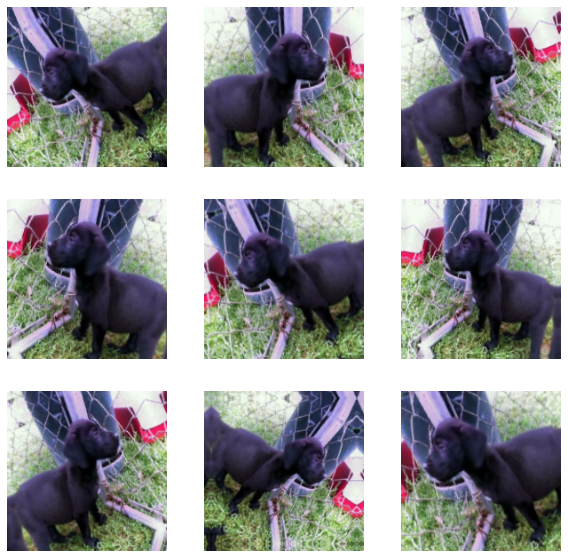

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Defining a new convnet that includes image augmentation and dropout**

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# **Training the regularized convnet**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20


500/500 [==============================] - 52s 94ms/step - loss: 0.6733 - accuracy: 0.5678 - val_loss: 0.6582 - val_accuracy: 0.5780
Epoch 2/20
500/500 [==============================] - 47s 93ms/step - loss: 0.6305 - accuracy: 0.6411 - val_loss: 0.6022 - val_accuracy: 0.6620
Epoch 3/20
500/500 [==============================] - 47s 93ms/step - loss: 0.5836 - accuracy: 0.6856 - val_loss: 0.5405 - val_accuracy: 0.7000
Epoch 4/20
500/500 [==============================] - 47s 93ms/step - loss: 0.5461 - accuracy: 0.7198 - val_loss: 0.5344 - val_accuracy: 0.7220
Epoch 5/20
500/500 [==============================] - 47s 93ms/step - loss: 0.4948 - accuracy: 0.7558 - val_loss: 0.4374 - val_accuracy: 0.8020
Epoch 6/20
500/500 [==============================] - 47s 94ms/step - loss: 0.4522 - accuracy: 0.7869 - val_loss: 0.4083 - val_accuracy: 0.8200
Epoch 7/20
500/500 [==============================] - 47s 93ms/step - loss: 0.4040 - accuracy: 0.8130 - val_loss: 0.3622 - val_accuracy: 0.8360
Epo

# **Evaluating the model on the test set**

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 0s 8ms/step - loss: 0.2034 - accuracy: 0.9040
Test accuracy: 0.904


# **Leveraging a pretrained model**
Feature extraction with a pretrained model
Instantiating the VGG16 convolutional base


In [24]:

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# **Fast feature extraction without data augmentation**
Extracting the VGG16 features and corresponding labels


In [26]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 28ms/step


In [27]:
train_features.shape

(16000, 5, 5, 512)

# **Defining and training the densely connected classifier**

In [28]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 7.8975 - accuracy: 0.9604 - val_loss: 3.1288 - val_accuracy: 0.9800
Epoch 2/20
500/500 [==============================] - 1s 3ms/step - loss: 2.8883 - accuracy: 0.9785 - val_loss: 5.7343 - val_accuracy: 0.9660
Epoch 3/20
500/500 [==============================] - 1s 3ms/step - loss: 1.5981 - accuracy: 0.9842 - val_loss: 1.4669 - val_accuracy: 0.9800
Epoch 4/20
500/500 [==============================] - 1s 3ms/step - loss: 1.0141 - accuracy: 0.9869 - val_loss: 2.9152 - val_accuracy: 0.9860
Epoch 5/20
500/500 [==============================] - 1s 3ms/step - loss: 0.7731 - accuracy: 0.9896 - val_loss: 2.8608 - val_accuracy: 0.9780
Epoch 6/20
500/500 [==============================] - 1s 3ms/step - loss: 0.4504 - accuracy: 0.9922 - val_loss: 2.5687 - val_accuracy: 0.9860
Epoch 7/20
500/500 [==============================] - 1s 3ms/step - loss: 0.4322 - accuracy: 0.9936 - val_loss: 3.5732 - val_accuracy: 0.9760
Epoch 

# **Plotting the results**

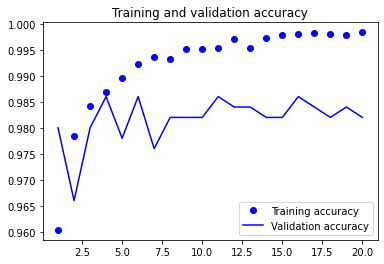

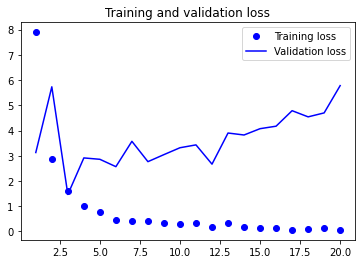

In [29]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Feature extraction together with data augmentation
# Instantiating and freezing the VGG16 convolutional base

In [30]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

# **Printing the list of trainable weights before and after freezing**

In [31]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [32]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


# **Adding a data augmentation stage and a classifier to the convolutional base**

In [33]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/20


500/500 [==============================] - 53s 100ms/step - loss: 8.7929 - accuracy: 0.9377 - val_loss: 3.5193 - val_accuracy: 0.9640
Epoch 2/20
500/500 [==============================] - 49s 99ms/step - loss: 2.8592 - accuracy: 0.9552 - val_loss: 1.0101 - val_accuracy: 0.9740
Epoch 3/20
500/500 [==============================] - 49s 99ms/step - loss: 0.9056 - accuracy: 0.9576 - val_loss: 0.7057 - val_accuracy: 0.9680
Epoch 4/20
500/500 [==============================] - 49s 99ms/step - loss: 0.6438 - accuracy: 0.9594 - val_loss: 0.6339 - val_accuracy: 0.9780
Epoch 5/20
500/500 [==============================] - 49s 99ms/step - loss: 0.6483 - accuracy: 0.9624 - val_loss: 0.4796 - val_accuracy: 0.9760
Epoch 6/20
500/500 [==============================] - 50s 99ms/step - loss: 0.6547 - accuracy: 0.9651 - val_loss: 0.5995 - val_accuracy: 0.9820
Epoch 7/20
500/500 [==============================] - 49s 99ms/step - loss: 0.6995 - accuracy: 0.9682 - val_loss: 0.7554 - val_accuracy: 0.9760
Ep

# **Evaluating the model on the test set**

In [35]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 16ms/step - loss: 0.3939 - accuracy: 0.9840
Test accuracy: 0.984


# **Fine-tuning a pretrained model**

In [36]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# **Freezing all layers until the fourth from the last**

In [37]:
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
    layer.trainable = False

# **Fine-tuning the model**

In [38]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20


500/500 [==============================] - 56s 102ms/step - loss: 0.8531 - accuracy: 0.9621 - val_loss: 0.4998 - val_accuracy: 0.9700
Epoch 2/20
500/500 [==============================] - 51s 101ms/step - loss: 0.3080 - accuracy: 0.9578 - val_loss: 0.1634 - val_accuracy: 0.9780
Epoch 3/20
500/500 [==============================] - 51s 101ms/step - loss: 0.1725 - accuracy: 0.9623 - val_loss: 0.1361 - val_accuracy: 0.9820
Epoch 4/20
500/500 [==============================] - 51s 101ms/step - loss: 0.1115 - accuracy: 0.9704 - val_loss: 0.1176 - val_accuracy: 0.9800
Epoch 5/20
500/500 [==============================] - 51s 101ms/step - loss: 0.0889 - accuracy: 0.9753 - val_loss: 0.1257 - val_accuracy: 0.9820
Epoch 6/20
500/500 [==============================] - 51s 102ms/step - loss: 0.0648 - accuracy: 0.9819 - val_loss: 0.1478 - val_accuracy: 0.9780
Epoch 7/20
500/500 [==============================] - 51s 101ms/step - loss: 0.0604 - accuracy: 0.9826 - val_loss: 0.1603 - val_accuracy: 0.9

In [39]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 16ms/step - loss: 0.0871 - accuracy: 0.9840
Test accuracy: 0.984
